In [1]:
object_list = [
  {"name": "garden_grassy_field", "description": "A large, lush, green grassy field serving as the base of the garden."},
  {"name": "playground_slide", "description": "A brightly colored children's slide made of plastic, with a smooth surface and gentle slope."},
  {"name": "playground_swing", "description": "A single swing with a wooden seat and metal chains, positioned in the garden area."},
  {"name": "little_girl", "description": "A young girl, around 7-10 years old, wearing a bright yellow sweater, a colorful dress, and high heels. She has an energetic and playful appearance."},
  {"name": "medium_dog", "description": "A medium-sized dog with a friendly demeanor, either standing or playfully interacting with the girl."}
]

In [2]:
# Current directory is assigned to HOME variable
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
# Cloning GroundingDINO repo
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

# Change to submit version "57535c5a79791cb76e36fdb64975271354f10251"
%cd {HOME}/GroundingDINO
# Install all dependencies
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 460 (delta 167), reused 146 (delta 135), pack-reused 233
Receiving objects: 100% (460/460), 12.87 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.2 MB/s eta 0:00:00


In [4]:
# Install SAM

import sys
# {sys.executable} is a placeholder that would be replaced by the path to the Python interpreter currently in use.
# -  For instance, if sys.executable is /usr/bin/python3, then !{sys.executable} will be replaced with !/usr/bin/python3.
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vib0rmdh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vib0rmdh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=c47ba4b06fb9066bce6947beaeca4892d92f9dff2a121ebfe3cee983aabe5ff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l99hsxn/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [5]:
# To glue all the elements of our demo together we will use the supervision pip package, which will help us process,
# filter and visualize our detections.

!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.22.0
Uninstalling supervision-0.22.0:
  Successfully uninstalled supervision-0.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision>=0.22.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [6]:
# Download GroudingDINO weight and config
# Config
import os
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

# Weight
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content
/content/weights


In [7]:
# Download SAM weight
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [8]:
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

In [12]:
# ----------------------------------------------------------------------------------------
# [!REMBEMBER]
# 1. Upload ảnh trong /content/
# 2. Trước khi loading model, thực hiện chỉnh sửa code mã nguồn trong Grounding DINO phần phrase2index như sau:
    # def phrases2classes(phrases: List[str], classes: List[str]) -> np.ndarray:
    #     class_ids = []
    #     print(phrases)
    #     print(classes)
    #     for phrase in phrases:
    #         for class_ in classes:
    #             if class_.replace(" ", "") in phrase.replace(" ", ""):
    #                 class_ids.append(classes.index(class_))
    #             else:
    #                 continue
    #     return np.array(class_ids)
# ----------------------------------------------------------------------------------------

In [9]:
# Loading Model
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading GroundingDINO
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import Model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

# Loading SAM
SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['all little _ girls all medium _ dogs']
['all garden_grassy_fields', 'all playground_slides', 'all playground_swings', 'all little_girls', 'all medium_dogs']
Detections(xyxy=array([[ 51.40332 ,  13.013351, 182.94379 , 221.91391 ]], dtype=float32), mask=None, confidence=array([0.42046753], dtype=float32), class_id=array([3, 4]), tracker_id=None)


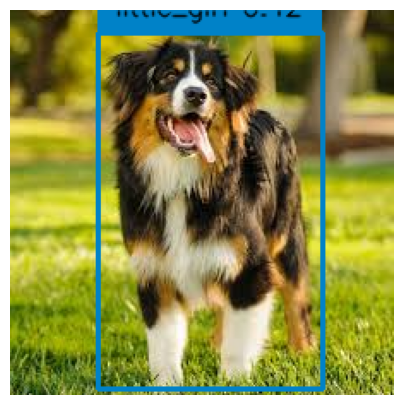

In [10]:
# Folder contain data
f"{HOME}/data"

# Image cần cắt
SOURCE_IMAGE_PATH = f"{HOME}/Image3.jpeg"

# Các class
CLASSES = [item["name"] for item in object_list]

BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

# Zero-Shot Object Detection with Grounding DINO

# Text enhance
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

# Detect
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

print(detections)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (5, 5))

In [11]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

Detections(xyxy=array([[ 51.40332 ,  13.013351, 182.94379 , 221.91391 ]], dtype=float32), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.42046753], dtype=float32), class_id=array([3, 4]), tracker_id=None)


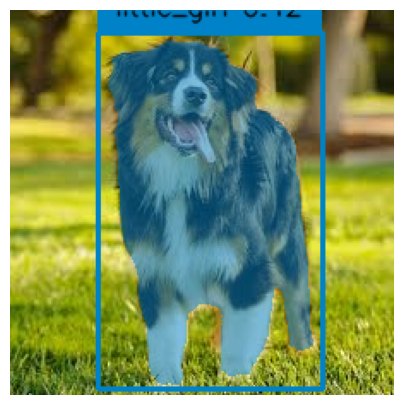

In [12]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)
print(detections)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (5, 5))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


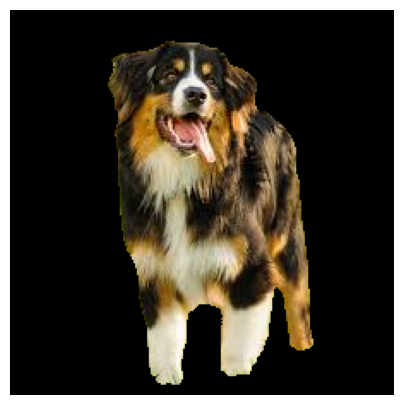

In [13]:
def apply_mask(image, mask):
    # Convert to numpy arrays
    image = np.array(image)
    mask = np.array(mask)
    # Convert grayscale image to RGB
    mask = np.stack((mask,)*3, axis=-1)
    # Multiply arrays
    resultant = image*mask
    return resultant

image_in = image
mask_in = detections.mask[0]

resultant = apply_mask(image_in, mask_in)
print(resultant)

sv.plot_image(resultant, (5, 5))

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.7 MB/s eta 0:00:00


In [1]:
# Using Diffusion Model to filling missing part

import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()

init_image = load_image("/content/Image_Crop.png")
prompt = "re-draw into a full body, 3D model of medium_dog"
image = pipeline(prompt, image=init_image).images[0]
make_image_grid([image], rows=1, cols=1)

KeyboardInterrupt: 

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [1]:
# Create 3D model from 2D images

%rm -r dreamgaussian
!git clone https://github.com/dreamgaussian/dreamgaussian
%cd dreamgaussian

# install dependencies
!pip install -q einops plyfile dearpygui huggingface_hub diffusers accelerate transformers xatlas trimesh PyMCubes pymeshlab rembg[gpu,cli] omegaconf ninja

# build extension
!git clone --recursive https://github.com/ashawkey/diff-gaussian-rasterization
!pip install -q ./diff-gaussian-rasterization
!pip install -q ./simple-knn

# nvdiffrast
!pip install -q git+https://github.com/NVlabs/nvdiffrast

# kiuikit
!pip install -q git+https://github.com/ashawkey/kiuikit

%mkdir -p data

rm: cannot remove 'dreamgaussian': No such file or directory
Cloning into 'dreamgaussian'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 229 (delta 123), reused 70 (delta 70), pack-reused 63
Receiving objects: 100% (229/229), 1.47 MiB | 3.95 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/dreamgaussian
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

/content/dreamgaussian/data


Saving mediun_dog.png to mediun_dog.png
/content/dreamgaussian


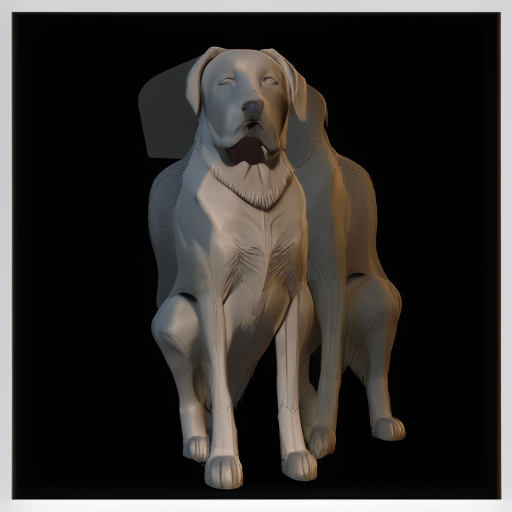

In [2]:
import os

%cd data/
%rm * # remove all old files!
from google.colab import files
uploaded = files.upload()
IMAGE = os.path.basename(next(iter(uploaded))) # filename
%cd ..

# display image
from IPython.display import Image, display
display(Image(f'data/{IMAGE}', width=256, height=256))

In [11]:
!pip install numpy

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 115GB/s]


[INFO] loading image data/mediun_dog.png...
[INFO] background removal...
[INFO] recenter...


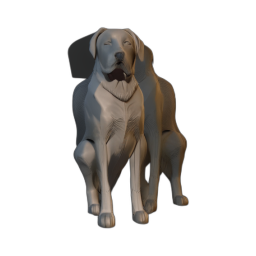

In [3]:
#@title preprocess image

# preprocess
%run process.py data/{IMAGE}

NAME = os.path.splitext(IMAGE)[0]
IMAGE_PROCESSED = NAME + '_rgba.png'

# display processed image
from IPython.display import Image, display
display(Image(f'data/{IMAGE_PROCESSED}', width=256, height=256))

In [4]:
#@markdown ####**Settings:**
Elevation = 0 #@param {type: 'integer'}

In [5]:
!sudo apt install cuda-12.2
#@title training!

# stage 1
%run main.py --config configs/image.yaml input=data/{IMAGE_PROCESSED} save_path={NAME} elevation={Elevation} force_cuda_rast=True

# stage 2
%run main2.py --config configs/image.yaml input=data/{IMAGE_PROCESSED} save_path={NAME} elevation={Elevation} force_cuda_rast=True

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package cuda-12.2
E: Couldn't find any package by glob 'cuda-12.2'
[INFO] load image from data/mediun_dog_rgba.png...
Number of points at initialisation :  5000
[INFO] loading zero123...


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

clip_camera_projection/config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

clip_camera_projection/zero123.py:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'trust_remote_code': True} are not expected by Zero123Pipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

[INFO] loaded zero123!


100%|██████████| 500/500 [01:14<00:00,  6.67it/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[INFO] save model to logs/mediun_dog_model.ply.


Tensor occ torch.Size([128, 128, 128]) torch.float32 cuda:0 ∈ [0.0, 54.95896911621094] μ = 0.37837669253349304 σ = 
1.9586488008499146

[INFO] mesh cleaning: (34392, 3) --> (26937, 3), (68780, 3) --> (53886, 3)
[INFO] marching cubes result: torch.Size([26937, 3]) (-0.7276073694229126-0.7642243504524231), torch.Size([53886, 3])
[INFO] unwrap uv...


/content/dreamgaussian/mesh.py:348: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  face_normals = torch.cross(v1 - v0, v2 - v0)
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[INFO] save model to logs/mediun_dog_mesh.obj.
[load_obj] use texture from: logs/mediun_dog_mesh_albedo.png
[load_obj] load texture: (1024, 1024, 3)
[Mesh loading] v: torch.Size([31909, 3]), f: torch.Size([53886, 3])
[Mesh loading] vn: torch.Size([31909, 3]), fn: torch.Size([53886, 3])
[INFO] load image from data/mediun_dog_rgba.png...
[INFO] loading zero123...


Keyword arguments {'trust_remote_code': True} are not expected by Zero123Pipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

[INFO] loaded zero123!


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


[INFO] save model to logs/mediun_dog.obj.


In [6]:
#@title render a video for displaying

# the final mesh is saved to ./logs/NAME.obj
%run -m kiui.render logs/{NAME}.obj --save_video {NAME}.mp4 --wogui --force_cuda_rast

from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width=450):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video(f'{NAME}.mp4')

[INFO] load obj mesh: use texture from: logs/mediun_dog_albedo.png
[INFO] load obj mesh: load texture: (1024, 1024, 3)
[INFO] load mesh, v: torch.Size([31909, 3]), f: torch.Size([53886, 3])
[INFO] load mesh, vn: torch.Size([31909, 3]), fn: torch.Size([53886, 3])
[INFO] load mesh, vt: torch.Size([31909, 2]), ft: torch.Size([53886, 3])


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
